#**Purchase Optimisation using Price and Demand Prediction for a Rice Manufacturing Firm**


---


**OPER60500A.H2022 - SUPPLY CHAIN ANALYTICS**


Presented to Prof Yossiri Adulyasak


---
*By*

Hua, Jianian (11301447)

Luo, Huiwen (11307985)

Nguyen, Trung (11274768)

Rakkiappasamy Raadha, Ragul Adhithya (11308360)


---



Submitted on Apr 17, 2022

# Introduction

## Background
ABC Ltd is a rice manufacturing firm founded in 1970 from India. It produces premium quality of rice varieties and sells them in different packages of 75 kgs, 25 kgs, 10 kgs, 5 kgs, and 1 kgs. They buy and sell only one variety of product to ensure quality consistency. They have been using traditional seasonal naïve forecasting for both demand and purchasing price as the managers are equipped with the tools and techniques to forecast. Their purchasing decision is based on the daily market price quote from the market. Sometime the prices increase for a few days and decreases due to market factors and increases overall cost of the goods. This affects their margins as their selling price is constant for fixed period. With the increased competition in the market, they are also forced to cut back cost of product and purchase price is significant component in it.



## Objective
To create an optimal purchasing plan to better match the supply and demand of the company with the minimum cost.

## Approach
We require the quantity required and price predictions. The quantity required is directly dependent on demand and we use demand predictions to determine the quantity of raw material required for production. Purchasing data with daily price is available. With the comparison of different demand forecasting methods, including moving average, exponential smoothing, holtwinters, random forest, and arima, we choose the best method by error measurement to predict the product quantity required in the future. As the quote from the market fluctuate frequently, we predict the price by the same approach in the demand forecasting. Finally, we use the optimization model to achieve the optimal purchasing plan.

#Importing Data

At first we impor the modules required to run the codes

In [108]:
import pandas as pd # Pandas for data frame
import numpy as np
import math # Math functions
from statsmodels.tsa.api import ExponentialSmoothing # ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal Decomposition
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error # MSE Error
from math import sqrt # SQRT
import statsmodels.api as sm # statsmodels

import warnings
warnings.filterwarnings("ignore")

Import Sales Excel File and assigning it to a dataframe (df_sales). The excel files contains the sales data with bill wise details from Apr 2018 to Mar 2021 (3 years data). The data contains the follwing details and given below the details of the data in the excel of sales.

1. trinvdate - Invoice Data
2. hname - Supplier name
3. trinvo - Invoice Number
4. trcash - Cash/Credit Sales
5. cquant - Product type sold based on packaging
6. trquan - Quantity of product type sold
7. trweight - Weight of the product in tonnes ( 1000kgs to 1 ton)
8. trrate - Price of the product type
9. tramount - trrate x trquant = value of product
10. advance - discount type 1 provided to to the supplier
11. lesamt - discount type 2 provided to the supplier
12. Subregion - Subregion of the supplier
13. Region of the supplier

Note: We have factorised the supplier name and changed certain pricing data to protect the confidential data of the company. 

In [109]:
#import io
#from google.colab import files
#uploaded = files.upload()

In [110]:
df_sales = pd.read_excel('Combined_Sales.xlsx')
df_sales.head()

,Unnamed: 0,trinvdate,hname,trinvno,trcash,cquant,trquan,trweight,trrate,tramount,advance,lesamt,SUBREGION,REGION
0,0,2018-04-01,CU0000,2,CR,BAG OF 75 KGS,27,2.025,2400.0,64800.0,0.0,0.0,TIRUPUR,TIRUPUR
1,1,2018-04-01,CU0001,3,CR,BAG OF 75 KGS,30,2.250,1920.0,57600.0,0.0,0.0,TIRUPUR,TIRUPUR
2,2,2018-04-01,CU0002,1,CR,BAG OF 75 KGS,25,1.875,2400.0,60000.0,0.0,0.0,TIRUPUR,TIRUPUR
3,3,2018-04-01,CU0003,4,CR,BAG OF 25 KGS,20,0.500,1088.0,21760.0,0.0,0.0,ERODE,ERODE
4,4,2018-04-01,CU0003,4,CR,BAG OF 10 KGS,30,0.300,444.0,13320.0,0.0,0.0,ERODE,ERODE


After loading the sales data, we load the purchase data into a dataframe (df_purchase). The column details of the data in excel is given below:

1. Date - Date of purchase
2. Customer_ID: Supplier Name
3. Vch Type - It shows whether it was a purchase or stock transfer or rice.
4. Vch No - Voucher Number
5. Quantity - Quanity of raw material purchase
6. Rate - Prices of raw material
7. Value - Product of rate and quantity

Note: here also we have facorised the supplier name and prices of raw material to protect the confidential data of the company

In [111]:
#uploaded = files.upload()

In [112]:
df_purchase = pd.read_excel('Combined-Purchase.xlsx')
df_purchase.head()

,Unnamed: 0,Date,Customer_ID,Vch Type,Vch No.,Quantity,Rate,Value
0,0,2018-04-01,CU0000,Purchase,1,21900.0,26.15,572685.0
1,1,2018-04-01,CU0001,Purchase,2,21400.0,25.96,555544.0
2,2,2018-04-01,CU0000,Purchase,3,22540.0,26.15,589421.0
3,3,2018-04-02,CU0000,Purchase,4,21440.0,26.62,570733.0
4,4,2018-04-02,CU0000,Purchase,5,21500.0,26.38,567170.0


# Preparing the dataset of Purchase

At first, I check if the dataset has any missing values. If there are any missing values, I drop all the missing values, using the attribute of how = 'any' in dropna.




In [113]:
df_purchase.isnull().sum()

Unnamed: 0       0
Date            14
Customer_ID      0
Vch Type        14
Vch No.         14
Quantity       161
Rate             0
Value          160
dtype: int64

In [114]:
df_purchase = df_purchase.dropna(how='any')
df_purchase.isnull().sum() # checking if any null values are present

Unnamed: 0     0
Date           0
Customer_ID    0
Vch Type       0
Vch No.        0
Quantity       0
Rate           0
Value          0
dtype: int64

From the purchase dataset, we extract only the important features used to predict purchase price. The feature extracted are date, prie and quantity purchased. We copy this into a new dataframe **df_price**. In the price dataframe, we add features like the month, year, date and week to analysis purpose. Month Name, Year Number and Month_N are taken from pandas DatetimeIndex. Week number is extracted from datetime module, which is imported



In [115]:
df_price = df_purchase[['Date','Rate','Quantity']].copy()
df_price.head()

,Date,Rate,Quantity
0,2018-04-01,26.15,21900.0
1,2018-04-01,25.96,21400.0
2,2018-04-01,26.15,22540.0
3,2018-04-02,26.62,21440.0
4,2018-04-02,26.38,21500.0


In [116]:
df_price['Month'] = pd.DatetimeIndex(df_price['Date']).month_name()
df_price['Year'] = pd.DatetimeIndex(df_price["Date"]).year
df_price['Month_N'] = pd.DatetimeIndex(df_price['Date']).month
from datetime import date
df_price['Week']= df_price['Date'].dt.isocalendar().week

# we convert the numbers to string, to ensure that there are no errors during grouping.
df_price["Year"]=df_price["Year"].astype(str) 

df_price.head()

,Date,Rate,Quantity,Month,Year,Month_N,Week
0,2018-04-01,26.15,21900.0,April,2018,4,13
1,2018-04-01,25.96,21400.0,April,2018,4,13
2,2018-04-01,26.15,22540.0,April,2018,4,13
3,2018-04-02,26.62,21440.0,April,2018,4,14
4,2018-04-02,26.38,21500.0,April,2018,4,14


In [117]:
df_price.dtypes
# Here we check if all the variables are in the right format

Date        datetime64[ns]
Rate               float64
Quantity           float64
Month               object
Year                object
Month_N              int64
Week                UInt32
dtype: object

In [118]:
df_purchase.groupby('Vch Type').mean()
# here we check that only purchase voucher types exists in the data

,Unnamed: 0,Quantity,Rate,Value
Vch Type,,,,
Purchase,772.661507,23214.706351,20.506663,514105.982085


In [119]:
# We group the price daily, based on the average rate of prices
df_price_d = df_price.groupby(['Year','Date'])['Rate'].mean().reset_index()

# Sorting the data according to the date
df_price_d.sort_values(['Year','Date'],inplace = True)

# We group the price monthly, based on the average rate of prices
whole_month_purchase = df_price.groupby(['Year','Month_N','Month'])['Rate'].mean().reset_index()

# Sorting the data according to the Month
whole_month_purchase.sort_values(['Year','Month_N','Month'],inplace = True)


In [120]:
whole_month_purchase.head()

,Year,Month_N,Month,Rate
0,2018,4,April,24.664641
1,2018,5,May,24.243100
2,2018,6,June,20.692139
3,2018,7,July,18.408679
4,2018,8,August,19.604040


# Preparing the dataset of Sales

As the same as we do for the purchase data, we check if the dataset has any missing values. If there are any missing values, we drop all the missing values  using the attribute of how = 'any' in dropna.

In [121]:
df_sales.dtypes

Unnamed: 0             int64
trinvdate     datetime64[ns]
hname                 object
trinvno                int64
trcash                object
cquant                object
trquan                 int64
trweight             float64
trrate               float64
tramount             float64
advance              float64
lesamt               float64
SUBREGION             object
REGION                object
dtype: object

In [122]:
df_sales.isnull().sum() #checking for missing values

Unnamed: 0       0
trinvdate        0
hname            0
trinvno          0
trcash           0
cquant           0
trquan           0
trweight         0
trrate           0
tramount         0
advance       1798
lesamt        1804
SUBREGION        0
REGION           0
dtype: int64

In [123]:
#here we drop all the rows with missing values
df_sales = df_sales.dropna(how='any')

#df_sales.isnull().sum()

In [124]:
df_sales.isnull().sum() #checking for missing values

Unnamed: 0    0
trinvdate     0
hname         0
trinvno       0
trcash        0
cquant        0
trquan        0
trweight      0
trrate        0
tramount      0
advance       0
lesamt        0
SUBREGION     0
REGION        0
dtype: int64

We rename the colomns for easier understanding.

In [125]:
#renaming the columns for sales dataframe
df_sales = df_sales.rename(columns = {'trinvdate':'Date','hname':'Party','trinvno':'No','trcash':'Cash/Credit',\
                 'cquant':'Bag','trquan':'Qty','trweight':'Weight', \
                     'trrate':'Price','tramount': 'Value', 'lesamt':'less','salesacamt':'Net_Value'})


In [126]:
df_sales = df_sales.loc[df_sales['Bag'] != 'BAGS'] # Remove the row with wrong data
df_sales.groupby(['Bag'])['Price'].mean()

Bag
BAG OF 1 KGS        41.506361
BAG OF 10 KGS      410.116667
BAG OF 100 KGS     626.666667
BAG OF 25 KGS      970.594589
BAG OF 5 KGS       205.638668
BAG OF 50 KGS     2152.640000
BAG OF 75 KGS     2760.228081
Name: Price, dtype: float64

We ignore all the cash sales as the company sells all their inferior products, which are resulr of production process.

In [127]:
#here we ignore all the cash sales due to business implications

df_sales = df_sales.loc[df_sales['Cash/Credit'] == "CR"]
df_sales.groupby('Cash/Credit').sum() # checking that only Credit Columns are taken into consideration

,Unnamed: 0,No,Qty,Weight,Price,Value,advance,less
Cash/Credit,,,,,,,,
CR,63396754,24787897,2914468,52047.444,15129535.2,2.079088e+09,-34079175.0,5945783.0


In [128]:
df_sales = df_sales.loc[df_sales['Bag'] != 'BAGS'] # Remove the row with wrong data
df_sales.groupby(['Bag'])['Price'].mean()

Bag
BAG OF 1 KGS        41.506361
BAG OF 10 KGS      412.141712
BAG OF 100 KGS     626.666667
BAG OF 25 KGS      988.050608
BAG OF 5 KGS       206.571341
BAG OF 50 KGS     2159.219048
BAG OF 75 KGS     2834.341836
Name: Price, dtype: float64

# Feature Enginnering

1. **Unit Weight of Product**: The company sells different types of product packing namely, 1,5,10,25,50,75 and 100 kg bags. We need this information to calculate the per unit cost. In order to extract this information, we use the Bag columns which contain bag details. We split the text and extract the only the numbers into a new column. For example, Bag of 1 KGS is split into 4 and the third split is assigned into a new column.

2. **Unit Price:** In order to calculate the unit price, we divide the price of the product with the unit weight. This will help to get the accurate pricing for forecasting demand.

3. **Adjusted Discount**: The discount consist of two components and we add them up to find the total discount offered to the supplier. An invoice can have multiple products, but only one single discount is offered to the supplier. Therefore, in the dataset, we can see that products with the same invoice numbers have discount being repeated for every product. Therefore, we need to calculate the adjusted discount

4. **Date Features**: Including the data features into the columns for grouping the dataset. We get the date, month name, month number, year and month year.

5. **Adjusted Unit Price**: Since the unit price does not take into consideration the discount, we calulcate the adjusted unit price. Adjusted unit price is difference of unit price and adjusted discount divided by weight, to get the discount per unit.

In [129]:
# Calculating the unit weight of the product
Weight = df_sales['Bag'].str.split(' ', n=4, expand = True) # Splitting the Bag into 4 parts
df_sales['Unit_weight'] = Weight[2] #Taking the third part number into a sperate column of df_sales
df_sales['Unit_weight'] = df_sales['Unit_weight'].astype(float) # converting the number to float

In [130]:
# Calculating the unit weight of the product

df_sales['Unit_Price'] = df_sales['Price']/df_sales['Unit_weight']


In [131]:
# Calculating the Month, Year, Day, Week, Month Year and Month Number
df_sales['Month'] = pd.DatetimeIndex(df_sales['Date']).month_name()
df_sales['Year'] = pd.DatetimeIndex(df_sales["Date"]).year
df_sales["Day"] = pd.DatetimeIndex(df_sales["Date"]).day_of_year
df_sales["Year"]= df_sales["Year"].astype(str)
df_sales['Month_N'] = pd.DatetimeIndex(df_sales['Date']).month
df_sales["Month_Year"]= df_sales["Month"] + df_sales["Year"]


As the same discount in the row data covered multiple lines in one order, we have to assign the discount to serveral lines in one order and calculate the unit price with discount. 

In [132]:
# Calculating Adjusted Discount based on weight of commodity in the invoice and calculting new Unit Price with Discount
df_group = df_sales.groupby(['Year','No']).agg(sum_w = ('Weight',sum)).reset_index()

df_sales.sort_values(['Year','No'])

df_sales = pd.merge(df_sales,df_group,on=['Year','No'],how='left')


We calculate the unit price with discount by the follow steps:
Firstly we calculate the propotion of the weight in each line by propotion = 
weight of one line / sum of the weight of serveral lines in one order​. 
Then we calculate the adjusted discount for each line​ by Adjusted Discount = propotion * discount.
Finally we calculate the unit price​ with discount by Discounted unit price = unit price - adjusted discount / weight of the line.

In [133]:
df_sales['less'] = df_sales['less'].astype(float) #converting the column numbers to float
df_sales['Discount'] = df_sales['less'] + abs(df_sales['advance']) # Calculating the total discount offered to the inoivce
df_sales['Adj_Dis'] = df_sales['Weight']/df_sales['sum_w']*df_sales['Discount'] # Calcutating the Adjusted Discount
df_sales['Dis_Unit_Price'] = round(df_sales['Unit_Price']-(df_sales['Adj_Dis']/(df_sales['Weight']*1000)),2)# Calculating the Ajdusted Unit Price


**Summary of Feature Enginnering**

In [134]:
df_sales[['Date','No','Bag','Weight','Price','less','advance','Discount','Unit_Price','Unit_weight','sum_w','Adj_Dis','Dis_Unit_Price']].loc[(df_sales['No']==8) & (df_sales['Year']=='2018')]

,Date,No,Bag,Weight,Price,less,advance,Discount,Unit_Price,Unit_weight,sum_w,Adj_Dis,Dis_Unit_Price
18,2018-04-01,8,BAG OF 25 KGS,3.125,1048.0,750.0,-3000.0,3750.0,41.92,25.0,6.45,1816.860465,41.34
19,2018-04-01,8,BAG OF 25 KGS,3.125,968.0,750.0,-3000.0,3750.0,38.72,25.0,6.45,1816.860465,38.14
20,2018-04-01,8,BAG OF 1 KGS,0.200,40.0,750.0,-3000.0,3750.0,40.00,1.0,6.45,116.279070,39.42


In [135]:
df_sales[['Date','Day','Month','Month_N','Month_Year','Year']].head()

,Date,Day,Month,Month_N,Month_Year,Year
0,2018-04-01,91,April,4,April2018,2018
1,2018-04-01,91,April,4,April2018,2018
2,2018-04-01,91,April,4,April2018,2018
3,2018-04-01,91,April,4,April2018,2018
4,2018-04-01,91,April,4,April2018,2018


# Descriptive Analysis

## Monthly Sales

We create different charts to show the relationships between the different variables in sales data.

In [136]:
df_bags = df_sales.groupby(['Year','Month','Month_N',"Month_Year"])['Qty'].sum().reset_index() # create a new dataframe for plotting. 
df_bags = df_bags.sort_values(by=['Year','Month_N'], ascending=True) # sort the row by month

We create 3 scatter plots to show the degree of dispersion of the sales data.

<AxesSubplot:xlabel='Total_Rice', ylabel='Price_Sales'>

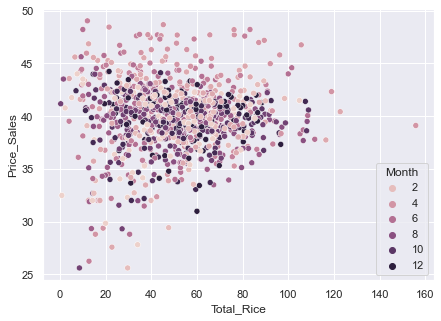

In [137]:
df_scatter = df_sales.groupby(['Date']).agg(Price_Sales = ('Dis_Unit_Price','mean'),Total_Rice =('Weight',sum),Month = ('Month_N','min'),Year=('Year','min'))
sns.set(rc={'figure.figsize':(7,5)})

sns.scatterplot(data=df_scatter, x="Total_Rice", y="Price_Sales",hue='Month')

In [138]:
df_scatter = pd.merge(df_scatter,df_price_d, on=['Date','Year'],how='left')
df_scatter = df_scatter.rename(columns = {'Rate':'Purchase_Price'})


<AxesSubplot:xlabel='Price_Sales', ylabel='Purchase_Price'>

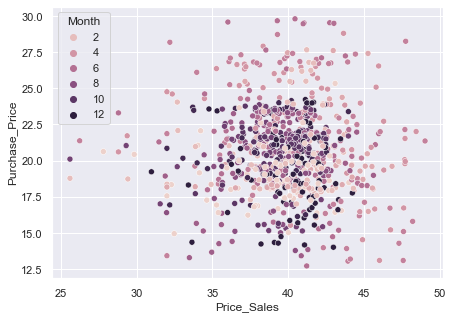

In [139]:
sns.scatterplot(data=df_scatter, x="Price_Sales", y="Purchase_Price",hue='Month')

<AxesSubplot:xlabel='Total_Rice', ylabel='Purchase_Price'>

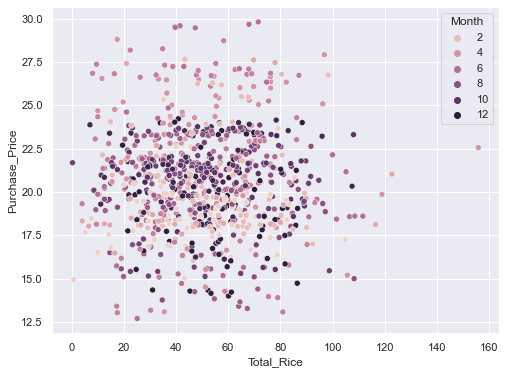

In [140]:
sns.set(rc={'figure.figsize':(8,6)})
sns.scatterplot(data=df_scatter, x="Total_Rice", y="Purchase_Price",hue='Month')

The three scatter plots shows the sales quantity and price data tends to be more agglomerated rather than discrete. The sales quantity is concentrated between 20 and 80, inidicating the maximum capacity of the plant. The sales price is concentrated between 35 and 45 and there are no big outliers found. However, there are certain deviations and we consider this to be normal as the quantity sold in less. We can also see that the purchase price is more volatile during the inital Months, comapred to sales price and sales quantity. This further substantiates our objective to predict accurate price and createa optimal purchase plan for the firm.

In [141]:
df_scatter.head()

,Date,Price_Sales,Total_Rice,Month,Year,Purchase_Price
0,2018-04-01,39.718438,69.775,4,2018,26.086667
1,2018-04-02,37.124074,82.300,4,2018,26.340000
2,2018-04-03,37.118000,54.600,4,2018,26.680000
3,2018-04-04,37.302381,68.100,4,2018,25.298571
4,2018-04-05,42.077500,32.000,4,2018,22.955000


### Monthly Sales Qty 

We create a line chart to show the fluctuation of the sales quantity.

<AxesSubplot:title={'center':'Monthly sales qty'}, xlabel='Month_Year', ylabel='Qty'>

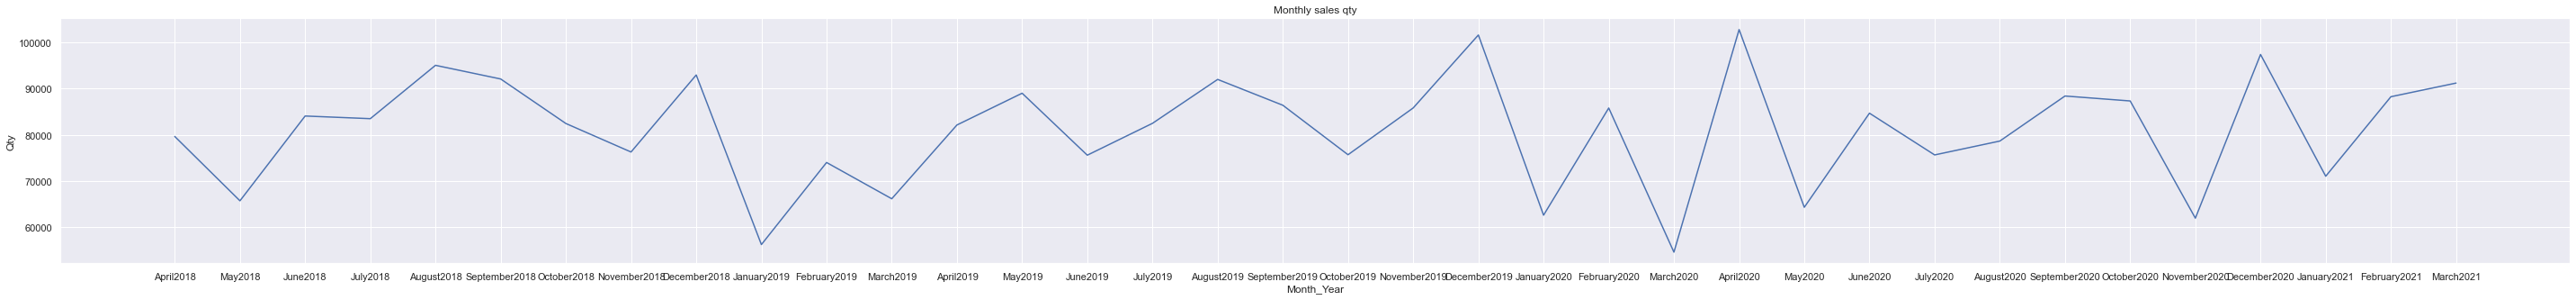

In [142]:
plt.figure(figsize=(50, 5))
plt.title('Monthly sales qty')
sns.lineplot(data=df_bags, x='Month_Year', y='Qty')

The chart shows there is seasonality in sales quantity. The company usually sells more products in December and August. 

### Monthly Sales Price Discount

We also create a line chart to show the fluctuation of the unit price with discount.

In [143]:
df_Discount_Month = df_sales.groupby(['Year','Month','Month_N'])['Dis_Unit_Price'].mean().reset_index() # Create a new dataframe for plotting
df_Discount_Month = df_Discount_Month.sort_values(by=['Year','Month_N'], ascending=True) # sort the row by month

<AxesSubplot:title={'center':'Monthly unit price with discount'}, xlabel='Month', ylabel='Dis_Unit_Price'>

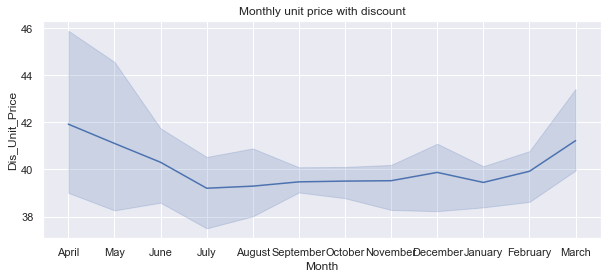

In [144]:
plt.figure(figsize=(10, 4))
plt.title('Monthly unit price with discount')
sns.lineplot(data=df_Discount_Month, x='Month', y='Dis_Unit_Price')

The chart shows the sales unit price is tend to be higher from March and June. This proves the seasonal nature of business being implicated in the sales.

## Monthly Purchase

### Monthly purchase price fluctuation

We create 2 linecharts to show the fluctuation of purchase price and purchase quantity.

In [145]:
df_price_month = df_price.groupby(['Year','Month_N','Month'])['Rate'].mean().reset_index() # create a new dataframe for plotting
df_price_month = df_price_month.sort_values(by=['Year','Month_N'], ascending=True) # sort the row by month


<AxesSubplot:title={'center':'Monthly purchase price fluctuation'}, xlabel='Month', ylabel='Rate'>

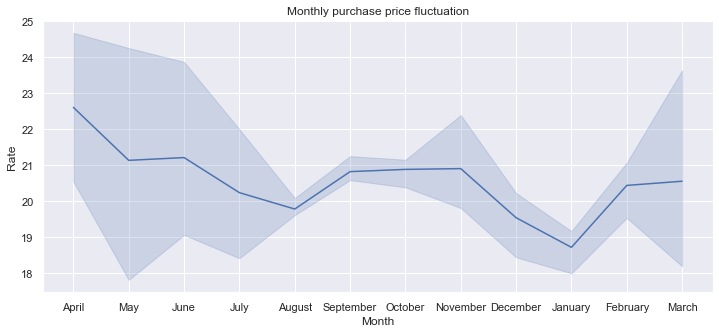

In [146]:
plt.figure(figsize=(12, 5))
plt.title('Monthly purchase price fluctuation')
sns.lineplot(data=df_price_month, x='Month', y='Rate')

The chart shows in January we have the lowest purchase price from our supplier.

### Monthly purchase quantity

In [147]:
df_purchase_month = df_price.groupby(['Year','Month_N','Month'])['Quantity'].sum().reset_index() # create a new dataframe for plotting
df_purchase_month = df_purchase_month.sort_values(by=['Year','Month_N'], ascending=True) # sort the row by month

<AxesSubplot:title={'center':'Monthly purchase quantity'}, xlabel='Month', ylabel='Quantity'>

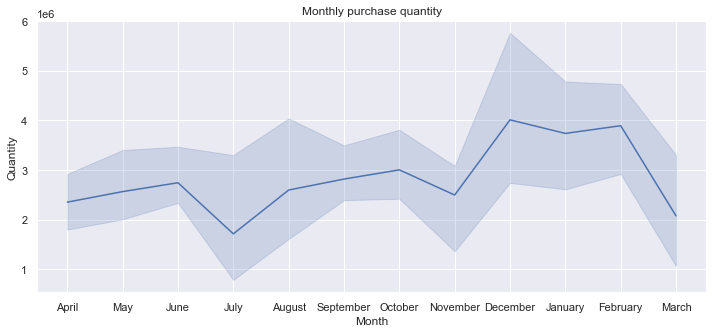

In [148]:
plt.figure(figsize=(12, 5))
plt.title('Monthly purchase quantity')
sns.lineplot(data=df_purchase_month, x='Month', y='Quantity')

The purchase price in December, January and February is relative high. The two charts obviously shows the company implement seansonal purchase to buy raw materials at the month with the lowest price.

# Demand Forecasting

We use both time series forecasting as well Random forecast to get the best forecasting tool suitable for this kind of data. Here we take Seasonal Naive Forecasting as our base model, as this method is used by the company. We split the data into 80% for training and 20% for out of sample testing. The following methods are used for demand forecasting:

1. Seasonal Naive Forecasting
2. Moving Average
3. Exponential Smoothing
4. Holt Winters
5. ARIMA
6. Random Forest

We choose the model with the lowest error. The method with the lowest RMSE and MAPE are chosen for the purpose of purchase optimisation.

In [149]:
#%% COnverting Daily Sales Data to Monthly Data

df_month = df_sales.groupby(['Year','Month_N','Month'])['Weight'].sum().reset_index()

df_month.sort_values(['Year','Month_N'], inplace = True)

whole_month_sales = df_month['Weight']
print(whole_month_sales[0:5])
df_month.head()


0    1541.185
1    1294.780
2    1660.284
3    1519.435
4    1770.925
Name: Weight, dtype: float64


,Year,Month_N,Month,Weight
0,2018,4,April,1541.185
1,2018,5,May,1294.780
2,2018,6,June,1660.284
3,2018,7,July,1519.435
4,2018,8,August,1770.925


In [150]:
# Here we create two dataframe. One dataframe to store all the forecaste values and other for errors
df_forecast = pd.DataFrame(columns=["seasonalNaiveForecast","movingAvg","Exponential_Smoothing","Holt_Winters","ARIMA","Random_Forest"])
df_errors = pd.DataFrame(columns=["RMSE","MAPE","MSE"])

In [151]:
# Calullating the total number of data points and determining the 80% mark
whole_month_sales= list(whole_month_sales)
n_periods = len(whole_month_sales)
print('Train',round(n_periods*0.8))
print('Total',n_periods)

Train 29
Total 36


### Defining the functions for Seasonal Naive Forecast, Moving Average,  Exponential Smoothing and Error Terms

In [152]:

#Defining functions for Seasonal Naive Forecasting, Moving Average and Exponential Smoothing.

# defining the naive forecast function
def seasonalNaiveForecast(sales, t, s):
  return sales[t-s]

# defininf the Moving Average Function
def movingAvg(sales, t, k):
    return sum(sales[t-k:t]) / k

# defining the Exponential Smoothing Function

def exponentialSmoothing(sales, t, alpha):
    exp_forecast = []
    exp_forecast.append(sales[0]) # assume the initial forecast (index 0) = actual demand in the same period
    for i in range(1, t+1):
      exp_forecast.append(alpha*sales[i-1]+(1-alpha)*exp_forecast[i-1])
    return  exp_forecast[t]



**Error Terms fucntions - MSE, MAPE AND RMSE**

Additionally, we will also define our errors measurement factors first. They are MSE, MAPE, and RMSE 

In [153]:
# MSE
def MSE(forecast, real_demand):
    sum_mse = 0
    n_periods = len(forecast)
    for t in range(n_periods):
        sum_mse += (real_demand[t] - forecast[t]) ** 2
    return (sum_mse/n_periods)


# MAPE
def MAPE(forecast, real_demand):
    n_periods = len(forecast)
    mape_t = [abs(real_demand[t] - forecast[t])/real_demand[t] for t in range(n_periods)] 
    return sum(mape_t)/n_periods

#RMSE
def RMSE(forecast,real_demand):
  rmse = mean_squared_error(forecast, real_demand)
  return math.sqrt(rmse)


### Seasonal Naive

To begin, we define the parameters. For seasonal naive fore cast, we initilize the model with the first value of ‘best_s’ being 0. As the calculation is carried on throughout model, these initial parameter of ‘s’ & ‘MAPE’ will be constantly re-evauluated. If the old values are better, it will be kept track of. Otherwise, new best value will be set.

After the model is run, we found ‘best_s’ being 10, with a respective MAPE of 0.1185; with other error measurements to be found at the end of our code. 


In [154]:

best_s = 0 # initialize the initial value of best s
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for s in range(2,12,2):
  #print("s = ", s)
  whole_month_sales_fcst_seasonnaive = [seasonalNaiveForecast(whole_month_sales, t, s) for t in range(29, 36)]
  whole_month_sales_fcst_seasonnaive_mape = MAPE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])
  #print("MAPE :", whole_month_sales_fcst_seasonnaive_mape)
  if whole_month_sales_fcst_seasonnaive_mape < best_mape: # keep track of the best s
    best_s = s # set the new best_s
    best_mape = whole_month_sales_fcst_seasonnaive_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best seasonality length s = ", best_s)
whole_month_sales_fcst_seasonnaive = [seasonalNaiveForecast(whole_month_sales, t, best_s) for t in range(29, 36)]
whole_month_sales_fcst_seasonnaive_mse = MSE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])
whole_month_sales_fcst_seasonnaive_mape = MAPE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])
whole_month_sales_fcst_seasonnaive_rmse = RMSE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])

# We append the result of forecast and errors to their respective dataframe
df_forecast["seasonalNaiveForecast"] = whole_month_sales_fcst_seasonnaive

df_errors.loc["seasonalNaiveForecast","MAPE"] = whole_month_sales_fcst_seasonnaive_mape
df_errors.loc["seasonalNaiveForecast","RMSE"] = whole_month_sales_fcst_seasonnaive_rmse
df_errors.loc["seasonalNaiveForecast","MSE"] = whole_month_sales_fcst_seasonnaive_mse


best seasonality length s =  8


### Moving Average


We first look at Moving average, a predictive tool where the next value will be calculated as the average of a certain k numbers of historical data that are immediately behind it. 

For this forecasting method, we initilize the model with the first value of ‘best_k’ being 0. The range of k will be from 2 to 6, with 6 being the maximum due to the limit amounts of data points we’re looking at.  As the calculation is carried on throughout model, these initial parameter of ‘k’ & ‘MAPE’ will be constantly re-evauluated. If the old values are better, it will be kept track of. Otherwise, new best value will be set.

In [155]:

best_k = 0 # initialize the initial value of best k
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for k in range(2,6):
  #print("k = ", k)
  whole_month_sales_fcst_movingavg = [movingAvg(whole_month_sales, t, k) for t in range(29, 36)]
  whole_month_sales_fcst_movingavg_mape = MAPE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])
  if whole_month_sales_fcst_movingavg_mape < best_mape: # keep track of the best parameter
    best_k = k # set the new best_k
    best_mape = whole_month_sales_fcst_movingavg_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best lookback length k = ", best_k)
whole_month_sales_fcst_movingavg = [movingAvg(whole_month_sales, t, best_k) for t in range(29, 36)]
whole_month_sales_fcst_movingavg_mse = MSE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])
whole_month_sales_fcst_movingavg_mape = MAPE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])
whole_month_sales_fcst_movingavg_rmse = RMSE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])

# We append the result of forecast and errors to their respective dataframe

df_forecast["movingAvg"] = whole_month_sales_fcst_movingavg

df_errors.loc["MovingAvg","MAPE"] = whole_month_sales_fcst_movingavg_mape
df_errors.loc["MovingAvg","RMSE"] = whole_month_sales_fcst_movingavg_rmse
df_errors.loc["MovingAvg","MSE"] = whole_month_sales_fcst_movingavg_mse



best lookback length k =  5


### Exponential Smoothing

Next method we will be employing is Exponential Smoothing. It assume no trend nor seasonality. Unlike moving average, it give exponentially declining weight to past observations. An important element here is the smoothing parameter alpha, or the weight given to the historical data point right before the current forecast. This alpha will be optimized as the model is run. 

For this forecasting method, we initilize the model with the first value of ‘best_alpha’ being 0. The range of alpha will be from 0.1 to 1 (100%).  As the calculation is carried on throughout model, these initial parameter of ‘alpha’ & ‘MAPE’ will be constantly re-evauluated. If the old values are better, it will be kept track of. Otherwise, new best value will be set.

After the model is run, we found ‘best_alpha’ being 0.1, with a respective MAPE of 14, and other error measurements to be found at the end of our code. 


In [156]:

best_alpha = 0 # initialize the initial value of best alpha
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for alpha in [0.1*i for i in range(1,10)]: 
  whole_month_sales_fcst_expsmooth = [exponentialSmoothing(whole_month_sales, t, alpha) for t in range(29, 36)]
  whole_month_sales_fcst_expsmooth_mape = MAPE(whole_month_sales_fcst_expsmooth, whole_month_sales[26:])
  if whole_month_sales_fcst_expsmooth_mape < best_mape: # keep track of the best parameter
    best_alpha = alpha # set the new best parameter
    best_mape = whole_month_sales_fcst_expsmooth_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best alpha = ", best_alpha)
whole_month_sales_fcst_expsmooth = [exponentialSmoothing(whole_month_sales, t, best_alpha) for t in range(29, 36)]
whole_month_sales_fcst_expsmooth_mse = MSE(whole_month_sales_fcst_expsmooth, whole_month_sales[29:])
whole_month_sales_fcst_expsmooth_mape = MAPE(whole_month_sales_fcst_expsmooth, whole_month_sales[29:])
whole_month_sales_fcst_expsmooth_rmse = RMSE(whole_month_sales_fcst_expsmooth, whole_month_sales[29:])

# We append the result of forecast and errors to their respective dataframe

df_forecast["Exponential_Smoothing"] = whole_month_sales_fcst_expsmooth

df_errors.loc["Exponential_Smoothing","MAPE"] = whole_month_sales_fcst_expsmooth_mape
df_errors.loc["Exponential_Smoothing","RMSE"] = whole_month_sales_fcst_expsmooth_rmse
df_errors.loc["Exponential_Smoothing","MSE"] = whole_month_sales_fcst_expsmooth_mse

best alpha =  0.1


### Holt Winters

Holt Winter is similar to Exponential Smoothing, except it also trends and a seasonal series that repeat every certain periods-defined as ‘i’ here.

We then traained and test the model, with i in range (2,13)

After the model is run, we found ‘best_i’ being , with a respective MAPE of 12, and other error measurements to be found at the end of our code.



In [157]:

n = len(whole_month_sales)
print(round(n*0.8))

train = whole_month_sales[0:(round(n*0.8))]
test = whole_month_sales[(round(n*0.8)):]

best_i = 0
best_mape = 1.0

for i in range (2,13):
    fit1 = ExponentialSmoothing(train ,seasonal_periods= i,trend='add', seasonal='add').fit()
    y_hat = list(fit1.forecast(len(test)))
    Exp_sales_mape = MAPE(y_hat,test)
    if Exp_sales_mape < best_mape: # keep track of the best s
      best_i = i # set the new best_s
      best_mape = Exp_sales_mape # set the new best_mape

Exp_model_sales = ExponentialSmoothing(train ,seasonal_periods= best_i,trend='add', seasonal='add').fit()
Exp_forecast_sales = list(Exp_model_sales.forecast(len(test)))
Exp_sales_mape = MAPE(Exp_forecast_sales,test)
Exp_sales_mse = MSE(Exp_forecast_sales,test)
Exp_sales_rmse = RMSE(Exp_forecast_sales,test)

# We append the result of forecast and errors to their respective dataframe

df_forecast["Holt_Winters"] = Exp_forecast_sales

df_errors.loc["Holt_Winters","MAPE"] = Exp_sales_mape
df_errors.loc["Holt_Winters","RMSE"] = Exp_sales_rmse
df_errors.loc["Holt_Winters","MSE"] = Exp_sales_mse

29


### ARIMA

ARIMA is Auto Regressive Integrated Moving Average and is a well know tool used in time series forecasting. We need to deteremine the paramteres p,q and d. We determine the p and q values using partial autocorrelation function (PACF) and autocorrealtion function (ACF) plots. d value is determined used stationarity test. Based on the estimated parameters, we use the statsmodels arima model package to do the analysis. The results are added to the dataframe.

In [158]:
# ADF Test

from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(whole_month_sales, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')



ADF Statistic: -8.412339631928294
p-value: 2.0874918439022987e-13
Critial Values:
   1%, -3.6327426647230316
Critial Values:
   5%, -2.9485102040816327
Critial Values:
   10%, -2.6130173469387756


Since the p-value is less than 0.05, we can say the data is stationary at lag 0. Therefore d value is 0.

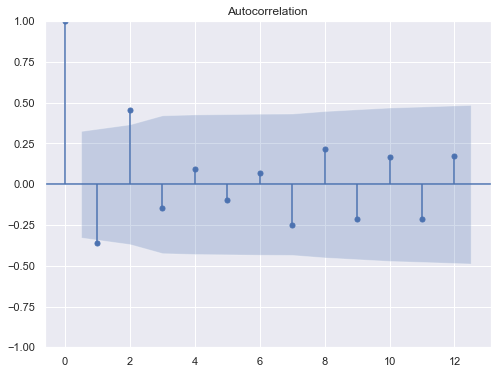

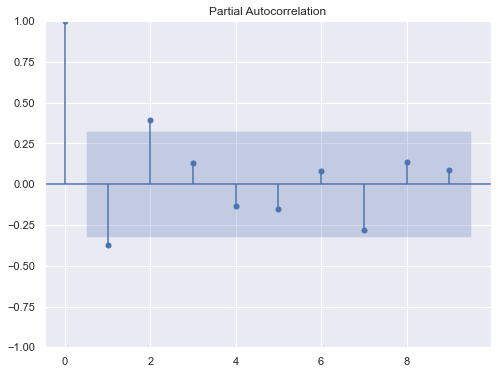

In [159]:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

ax1 = fig.add_subplot()
fig = sm.graphics.tsa.plot_acf(whole_month_sales,lags=12)
plt.show()

ax2 = fig.add_subplot()
fig = sm.graphics.tsa.plot_pacf(whole_month_sales,lags=9)
plt.show()


Based on the ACF and PCF Plots, we can determine that the best values for P and Q of ARIMA model is 2 and 2, as the line goes above the blue line, which indicates that the lags value are significant for those two levels.

In [160]:


# 2,0,2 ARIMA Model - Based on ACF, PCF Plot and stationarity test
model = sm.tsa.arima.ARIMA(whole_month_sales, order=(2,0,2))
model_fit = model.fit()


# Forecast
fc= model_fit.forecast(len(test))
print(model_fit.summary())

rmse_sales_arima = sqrt(mean_squared_error(test, fc))
print(rmse_sales_arima)

mape_sales_arima = MAPE(test, fc)
print(mape_sales_arima)

mse_sales_arima = MSE(fc,test)
print(mse_sales_arima)

# We append the result of forecast and errors to their respective dataframe

df_forecast["ARIMA"] = fc

df_errors.loc["ARIMA","MAPE"] = mape_sales_arima
df_errors.loc["ARIMA","RMSE"] = rmse_sales_arima
df_errors.loc["ARIMA","MSE"] = mse_sales_arima



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -238.161
Date:                Sun, 17 Apr 2022   AIC                            488.322
Time:                        15:59:34   BIC                            497.823
Sample:                             0   HQIC                           491.638
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1446.2600     39.420     36.688      0.000    1368.998    1523.522
ar.L1         -0.1563      0.468     -0.334      0.738      -1.073       0.760
ar.L2          0.2094      0.438      0.478      0.6

### Random Forest

Random Forest is a supervised machine learning algorithm used in classification and regression problems. For using Random Forest, we need feature inputs to predict the demand. In this case, we have used three feature inputs namely, sum of total discount offered in the month, average unit price of sales and average unit purchase price. We use these feature inputs to predict the demand.We use the RandomForestRegressor module from Sklearn for prediction. We also run a grid search to find the best parameters and improve the accuracy of predictions, to get the best results. 

In [161]:
df_random = df_sales.copy() # Making a copy of sales df

In [162]:
# Taking out the neccessary columns
df_random = df_random[['Date','Year','Month','Weight','Adj_Dis','Dis_Unit_Price']]

# Grouping it by Month
df_rand = df_random.groupby(['Year','Month']).\
agg(sum_weight=('Weight',sum),Discount=('Adj_Dis','sum'),\
    Unit_Rate = ('Dis_Unit_Price','mean')).reset_index()

# Sorting values on monthly basis
df_rand = df_rand.sort_values(['Year','Month'])

# Add unit purchase price to the dataframe of random forest
df_rand = pd.merge(df_rand, whole_month_purchase,on=['Year','Month'] ,how = 'left')


In [163]:
# Viewing the input features
df_rand.head()

,Year,Month,sum_weight,Discount,Unit_Rate,Month_N,Rate
0,2018,April,1541.185,354095.0,39.006129,4,24.664641
1,2018,August,1770.925,317615.0,38.007234,8,19.604040
2,2018,December,1683.025,400950.0,38.225722,12,20.218720
3,2018,July,1519.435,337116.0,37.495230,7,18.408679
4,2018,June,1660.284,466985.0,38.586015,6,20.692139


In [164]:
# Deleting the unneccsary columns
del df_rand['Month']
del df_rand['Year']
del df_rand['Month_N']


# Creating a label and feature list
labels = np.array(df_rand['sum_weight'])
feature_list = list(df_rand.columns.values)
                          
del df_rand['sum_weight'] # removing the predictor from the df rand
df_rand = np.array(df_rand)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(df_rand, labels, test_size = round(n*0.2), random_state = 1000)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions_demand_rf= rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions_demand_rf - test_labels)
# Print out the mean absolute error (mae)
mse_sales_rf = MSE(test_labels,predictions_demand_rf)
print("MSE of Random Forest Demand: ",mse_sales_rf)
mape_sales_rf = MAPE(test_labels,predictions_demand_rf)
print(mape_sales_rf*100)

rmse_sales_rf = math.sqrt(mean_squared_error(test_labels, predictions_demand_rf))
print('RMSE of Random Forest =',round(rmse_sales_rf))


Training Features Shape: (29, 3)
Training Labels Shape: (29,)
Testing Features Shape: (7, 3)
Testing Labels Shape: (7,)
MSE of Random Forest Demand:  11353.717017971054
5.981044812805438
RMSE of Random Forest = 107


Initating GRID search to find the best parameter value for the Random Forest
and improve the accuracy of predictions



In [165]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
# Create a based model
rf = RandomForestRegressor()

#Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3,\
                           n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
grid_search.best_params_


best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 104.5698.
Accuracy = 93.20%.
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Model Performance
Average Error: 73.1651.
Accuracy = 95.25%.
Improvement of 2.19%.


In [166]:
# Using the best grid parameters for getting the forecast and error terms
predictions_demand_rf = best_grid.predict(test_features)
mape_sales_rf = MAPE(predictions_demand_rf,test_labels)
rmse_sales_rf = math.sqrt(mean_squared_error(test_labels, predictions_demand_rf))
mse_sales_rf = MSE(predictions_demand_rf,test_labels)

In [167]:
# Adding the forecast and error terms to their respective data frame
df_forecast_rf = pd.DataFrame(columns =["Random_Forest"])
df_forecast["Random_Forest"] = predictions_demand_rf

df_errors.loc["Random_Forest","MAPE"] = mape_sales_rf
df_errors.loc["Random_Forest","RMSE"] = rmse_sales_rf
df_errors.loc["Random_Forest","MSE"] = mse_sales_rf

### Results of Demand Predictions

The results of demand predictions are shown below. From the forecast results, we can see tha **Random Forest** is the best tool for demand predictios, with the lowest MAPE(5%) and RMSE (91 tonnes).

In [168]:
df_forecast['Test'] = test
df_forecast.head(6)

,seasonalNaiveForecast,movingAvg,Exponential_Smoothing,Holt_Winters,ARIMA,Random_Forest,Test
0,1111.975,1377.475,1385.422193,1330.676357,1463.572427,1506.823882,1449.830
1,1545.175,1321.446,1391.862974,1383.428502,1540.972554,1439.678048,1559.530
2,903.025,1406.717,1408.629677,1068.914921,1435.083657,1513.333861,1095.050
3,1729.975,1326.952,1377.271709,1443.988005,1467.839656,1484.963012,1710.865
4,1133.175,1410.620,1410.631038,1079.913008,1440.547208,1456.379187,1292.975
5,1493.875,1421.650,1398.865434,1301.952684,1451.671630,1284.565235,1642.175


In [169]:
df_errors

,RMSE,MAPE,MSE
seasonalNaiveForecast,208.7561,0.120546,43579.109343
MovingAvg,237.198765,0.147776,56263.254193
Exponential_Smoothing,224.52115,0.141834,50409.746983
Holt_Winters,254.163946,0.143526,64599.311257
ARIMA,194.012778,0.111135,37640.958177
Random_Forest,96.87907,0.04752,9385.554119


# Purchase Price Predictions

We predict the purchase price of raw material using the purchase dataset. The purchase dataset provides daily purchase prices. Since the prices of the commodity fluctuate daily, we also do daily price predictions using the same tools and methodology used in the demand predictions. However, in this case we use SARIMA, which is an extension of ARIMA and include seasonality of predictions. Here also, we split the data into 80% for training and 20% for testing. The following tools are employed to choose the best tool for daily purchase price predictions.

1. Seasonal Naive Forecasting
2. Moving Average
3. Exponential Smoothing
4. Holt Winters
5. ARIMA
6. SARIMA
7. Random Forest


In [170]:
# Here we create two dataframe. One dataframe to store all the forecaste values and other for errors
df_forecast_price = pd.DataFrame(columns=["seasonalNaiveForecast","Exponential_Smoothing","Holt_Winters","ARIMA","SARIMA","Random_Forest"])
df_errors_price = pd.DataFrame(columns=["RMSE","MAPE","MSE"])
print(df_price_d.tail())

     Year       Date     Rate
886  2021 2021-03-26  18.1420
887  2021 2021-03-27  18.3700
888  2021 2021-03-28  18.3200
889  2021 2021-03-30  18.2525
890  2021 2021-03-31  18.1700


In [171]:
# Splitting the data into test and train set
purchase = df_price_d

purchase = list(df_price_d['Rate'])

n = len(purchase)
print('Total',n)
print('Train',round(n*0.8))

train_price = purchase[0:(round(n*0.8))]
test_price = purchase[(round(n*0.8)):]




Total 891
Train 713


## Seasonal Navie Forecasting

We use the same methodology used in demand prediction. We find the best s value based on MAPE.

In [172]:

best_s = 0 # initialize the initial value of best s
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for s in range(2,180):
  #print("s = ", s)
  purchase_fcst_seasonnaive = [seasonalNaiveForecast(purchase, t, s) \
                               for t in range(713, 891)]
  purchase_fcst_seasonnaive_mape = MAPE(purchase_fcst_seasonnaive, purchase[713:])
  #print("MAPE :", purchase_fcst_seasonnaive_mape)
  if purchase_fcst_seasonnaive_mape < best_mape: # keep track of the best s
    best_s = s # set the new best_s
    best_mape = purchase_fcst_seasonnaive_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best seasonality length s = ", best_s)
purchase_fcst_seasonnaive = [seasonalNaiveForecast(purchase, t, best_s) \
                             for t in range(713, 891)]
purchase_fcst_seasonnaive_mse = MSE(purchase_fcst_seasonnaive, purchase[713:])
purchase_fcst_seasonnaive_mape = MAPE(purchase_fcst_seasonnaive, purchase[713:])
purchase_fcst_seasonnaive_rmse = RMSE(purchase_fcst_seasonnaive, purchase[713:])

# Adding forecast and error terms to their respective dataframe

df_forecast_price["seasonalNaiveForecast"] = purchase_fcst_seasonnaive

df_errors_price.loc["seasonalNaiveForecast","MAPE"] = purchase_fcst_seasonnaive_mape
df_errors_price.loc["seasonalNaiveForecast","RMSE"] = purchase_fcst_seasonnaive_rmse
df_errors_price.loc["seasonalNaiveForecast","MSE"] = purchase_fcst_seasonnaive_mse




best seasonality length s =  2


## Moving Average

We use the same methodology used in demand prediction.We find the best k value based on lowest MAPE.

In [173]:

best_k = 0 # initialize the initial value of best k
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for k in range(2,180):
  #print("k = ", k)
  purchase_fcst_movingavg = [movingAvg(purchase, t, k) for t in range(713, 891)]
  purchase_fcst_movingavg_mape = MAPE(purchase_fcst_movingavg, purchase[713:])
  if purchase_fcst_movingavg_mape < best_mape: # keep track of the best parameter
    best_k = k # set the new best_k
    best_mape = purchase_fcst_movingavg_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best lookback length k = ", best_k)
purchase_fcst_movingavg = [movingAvg(purchase, t, best_k) for t in range(713, 891)]
purchase_fcst_movingavg_mse = MSE(purchase_fcst_movingavg, purchase[713:])
purchase_fcst_movingavg_mape = MAPE(purchase_fcst_movingavg, purchase[713:])
purchase_fcst_movingavg_rmse = RMSE(purchase_fcst_movingavg, purchase[713:])

# Adding forecast and error terms to their respective dataframe
df_forecast_price["MovingAvging"] = purchase_fcst_movingavg

df_errors_price.loc["MovingAvging","MAPE"] = purchase_fcst_movingavg_mape
df_errors_price.loc["MovingAvging","RMSE"] = purchase_fcst_movingavg_rmse
df_errors_price.loc["MovingAvging","MSE"] = purchase_fcst_movingavg_mse




best lookback length k =  2


## Exponential Smoothing

We use the same methodology used in demand prediction. We find the best aplha value based on lowest MAPE.

In [174]:

best_alpha = 0 # initialize the initial value of best alpha
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for alpha in [0.1*i for i in range(1,10)]: 
  purchase_fcst_expsmooth = [exponentialSmoothing(purchase, t, alpha) for t in range(713, 891)]
  purchase_fcst_expsmooth_mape = MAPE(purchase_fcst_expsmooth, purchase[26:])
  if purchase_fcst_expsmooth_mape < best_mape: # keep track of the best parameter
    best_alpha = alpha # set the new best parameter
    best_mape = purchase_fcst_expsmooth_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best alpha = ", best_alpha)
purchase_fcst_expsmooth = [exponentialSmoothing(purchase, t, best_alpha) for t in range(713, 891)]
purchase_fcst_expsmooth_mse = MSE(purchase_fcst_expsmooth, purchase[713:])
purchase_fcst_expsmooth_mape = MAPE(purchase_fcst_expsmooth, purchase[713:])
purchase_fcst_expsmooth_rmse = RMSE(purchase_fcst_expsmooth, purchase[713:])

# Adding forecast and error terms to their respective dataframe
df_forecast_price["Exponential_Smoothing"] = purchase_fcst_expsmooth

df_errors_price.loc["Exponential_Smoothing","MAPE"] = purchase_fcst_expsmooth_mape
df_errors_price.loc["Exponential_Smoothing","RMSE"] = purchase_fcst_expsmooth_rmse
df_errors_price.loc["Exponential_Smoothing","MSE"] = purchase_fcst_expsmooth_mse

best alpha =  0.1


## Holt Winters

We use the same methodology used in demand prediction.We find the best i value based on lowest MAPE.

In [175]:

best_i = 0
best_mape = 1.0

for i in range (2,30):
    fit1 = ExponentialSmoothing(train_price ,seasonal_periods= i,trend='add', seasonal='add').fit()
    y_hat = list(fit1.forecast(len(test_price)))
    Exp_purchase_mape = MAPE(y_hat,test_price)
    if Exp_purchase_mape < best_mape: # keep track of the best s
      best_i = i # set the new best_s
      best_mape = Exp_purchase_mape # set the new best_mape

Exp_model_purchase = ExponentialSmoothing(train_price ,seasonal_periods= best_i,trend='add', seasonal='add').fit()
Exp_forecast_purchase = list(Exp_model_purchase.forecast(len(test_price)))
Exp_purchase_mape = MAPE(Exp_forecast_purchase,test_price)
Exp_purchase_mse = MSE(Exp_forecast_purchase,test_price)
Exp_purchase_rmse = RMSE(Exp_forecast_purchase,test_price)

# Adding forecast and error terms to their respective dataframe
df_forecast_price["Holt_Winters"] = Exp_forecast_purchase

df_errors_price.loc["Holt_Winters","MAPE"] = Exp_purchase_mape
df_errors_price.loc["Holt_Winters","RMSE"] = Exp_purchase_rmse
df_errors_price.loc["Holt_Winters","MSE"] = Exp_purchase_mse

In [176]:
print(best_i)

24


## ARIMA

In the ARIMA method, we employ the same methodology. We find the best values for p and q using PACF and ACF plots and d value based on stationarity

### ADF Test

In [177]:
# We take the first lag as the data was not stationary at normal.
df_price_diff = pd.DataFrame()
df_price_diff['log'] =  df_price_d['Rate'].diff()

df_price_diff.dropna(how='any')
purchase_diff = list(df_price_diff['log'])
purchase_diff = purchase_diff[1:]

In [178]:

from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(purchase_diff, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -11.057687619122483
p-value: 4.897829555111819e-20
Critial Values:
   1%, -3.4378713927343156
Critial Values:
   5%, -2.8648601928465505
Critial Values:
   10%, -2.568537914369582


**Here also, we can see that the data is stationary, there the value of d in ARIMA is 1.**

---



### ACF and PCF Plots

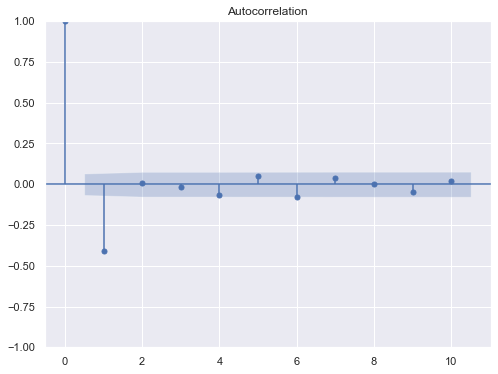

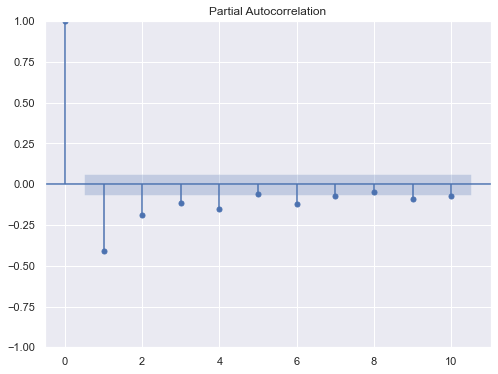

In [179]:
ax1 = fig.add_subplot()
fig = sm.graphics.tsa.plot_acf(purchase_diff,lags=10)
plt.show()
ax2 = fig.add_subplot()
fig = sm.graphics.tsa.plot_pacf(purchase_diff,lags=10)


From the ACF and PACF plots, we can conclude that the p and q value for ARIMA is 1 and 1.

### ARIMA

In [180]:

# Build Model
  
model = sm.tsa.arima.ARIMA(train_price, order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test_price))

# Make as pandas series
fc_series = pd.Series(fc)


rmse_price_arima = sqrt(mean_squared_error(test_price, fc_series))
print(rmse_price_arima)

1.8668196953094816


In [181]:
rmse_purchase_arima = sqrt(mean_squared_error(test_price, fc_series))
print(rmse_purchase_arima)

mape_purchase_arima = MAPE(test_price, fc_series)
print(mape_purchase_arima)

mse_purchase_arima = MSE(fc_series,test_price)

df_forecast_price["ARIMA"] = fc

df_errors_price.loc["ARIMA","MAPE"] = mape_purchase_arima
df_errors_price.loc["ARIMA","RMSE"] = rmse_purchase_arima
df_errors_price.loc["ARIMA","MSE"] = mse_purchase_arima

1.8668196953094816
0.07630629730252876


## SARIMA

Since we cannot use PACF and ACF plots to find the best values of p and q in case of SARIMA, we use grid search to find the best parameters for p,d,q,P,D,Q and M. We use a grid search to find the best parameters. Since the grid search takes a long time to run, we have not embedded the code into the notebook and include it as text. According to the grid search, the best values for is (2,1,1) for p,d, and q and (2,1,2,12) for P,D,Q and M.



```
# import itertools

#set parameter range

p = range(0,3)
q= range(0,3)
d = [0, 1]
s = [0,10,12]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
df6=pd.DataFrame(columns=["AIC","Attributes"])
i=0
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_price,order = param, seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            df6.loc[i,"AIC"]=results.aic
            add_list=list(param + param_seasonal)
            df6.loc[i,"Attributes"]=add_list
        except:
            continue
    i=i+1
    
df6.sort_values(['AIC'])

df6.head()
```
Result of GRID Search IMAGE
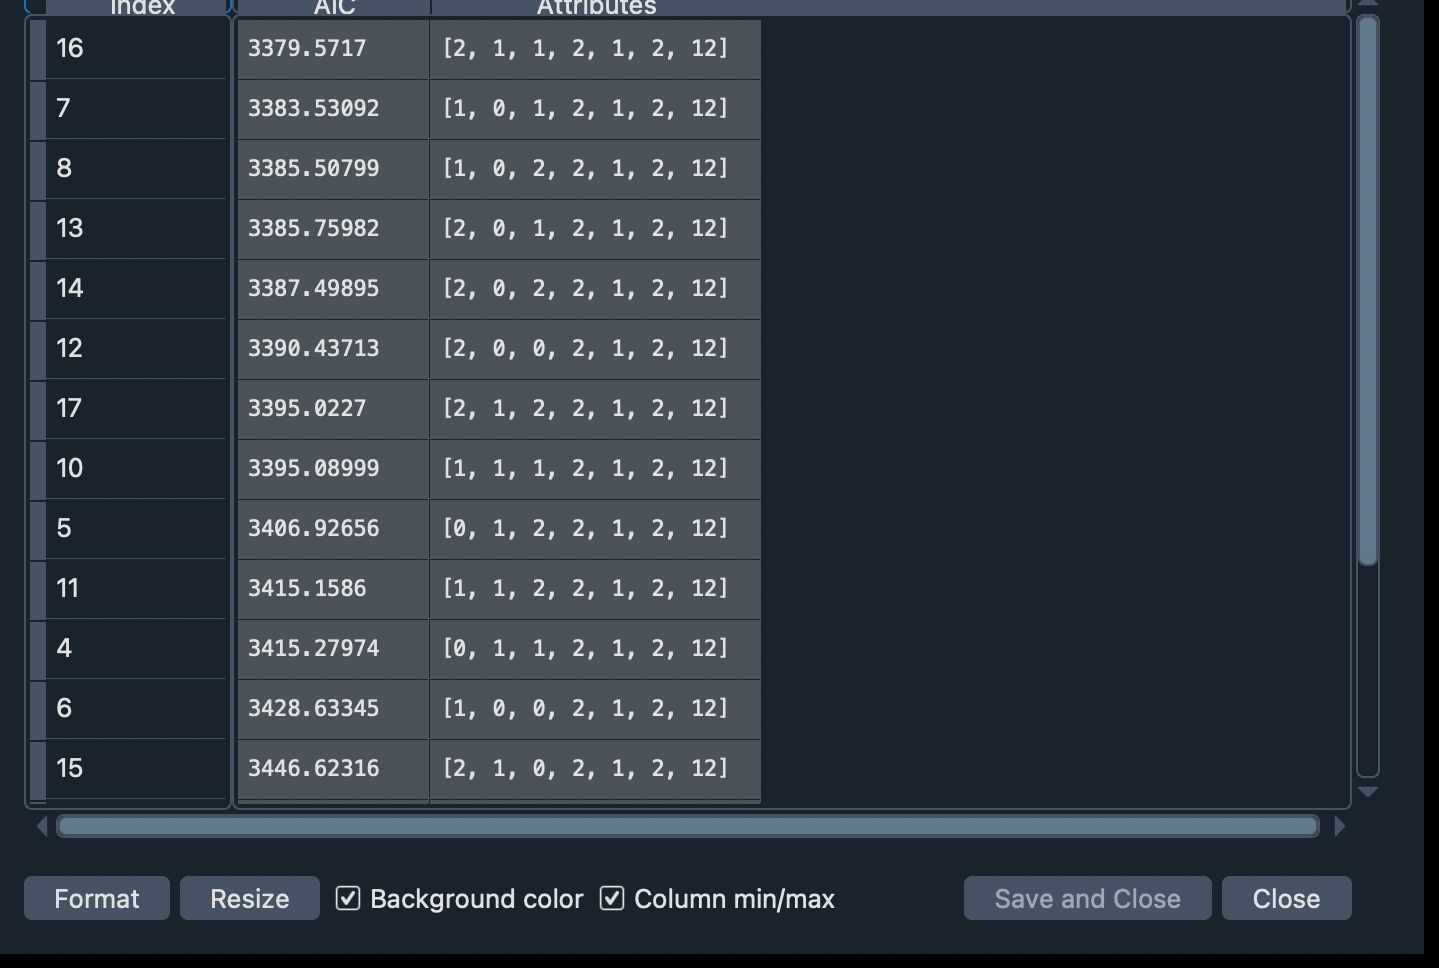


In [182]:

# SARIMA

model = sm.tsa.statespace.SARIMAX(train_price, order=(2, 1, 1),\
                                  seasonal_order=(2,1,2,12))  
fitted = model.fit()  

print(fitted.summary())
# Forecast
fc = fitted.forecast(len(test_price))

# Make as pandas series
fc_series = pd.Series(data = fc)

rmse_price_sarimax = sqrt(mean_squared_error(test_price, fc_series))
print(rmse_price_sarimax)
mape_price_sarimax = MAPE(test_price, fc_series)
mse_price_sarimax = MSE(test_price, fc_series)

df_forecast_price["SARIMA"] = fc_series

df_errors_price.loc["SARIMA","MAPE"] = mape_price_sarimax
df_errors_price.loc["SARIMA","RMSE"] = rmse_price_sarimax
df_errors_price.loc["SARIMA","MSE"] = mse_price_sarimax


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51804D+00    |proj g|=  1.05111D-01

At iterate    5    f=  2.38784D+00    |proj g|=  2.44646D-02

At iterate   10    f=  2.35932D+00    |proj g|=  2.06390D-02

At iterate   15    f=  2.35761D+00    |proj g|=  4.38156D-04

At iterate   20    f=  2.35748D+00    |proj g|=  4.74978D-03

At iterate   25    f=  2.35717D+00    |proj g|=  8.60074D-04

At iterate   30    f=  2.35710D+00    |proj g|=  9.76562D-04

At iterate   35    f=  2.35709D+00    |proj g|=  1.69005D-04

At iterate   40    f=  2.35708D+00    |proj g|=  6.02967D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

## Random Forest

In the Random Forest, we use the four features for prediction of purchase price. The features are quantity purchased, sum of discount offered on sales, lagged values of units sold and price of unit sales. Here we have taken lagged value of unit sold as it cannot be determined before hand the number of units sold in the month. Again, we use grid search to find the best parameters for Random Forest and improve the accuracy of predictions. 

In [183]:
df_2 = df_price.groupby(['Year','Date']).agg(sum_q=('Quantity',sum),\
                                             price = ('Rate','mean')).\
                                             reset_index()

df_2.sort_values(['Year','Date'],inplace =True)

df_3 = df_sales.groupby(['Year','Date']).agg(sum_weight=('Weight',sum),\
                                             Discount=('Adj_Dis','sum'),\
                                             Unit_Rate = ('Dis_Unit_Price',\
                                                          'mean')).reset_index()

df_3[['sum_weight']] = df_3[['sum_weight']].shift(1,axis=0)
df_randprice = pd.merge(df_3, df_2,on=['Year','Date'] ,how = 'left')


In [184]:
df_randprice.head()

,Year,Date,sum_weight,Discount,Unit_Rate,sum_q,price
0,2018,2018-04-01,NaN,25000.0,39.718438,65840.0,26.086667
1,2018,2018-04-02,69.775,14030.0,37.124074,95970.0,26.340000
2,2018,2018-04-03,82.300,19460.0,37.118000,21800.0,26.680000
3,2018,2018-04-04,54.600,18450.0,37.302381,124015.0,25.298571
4,2018,2018-04-05,68.100,13150.0,42.077500,44070.0,22.955000


In [185]:

df_randprice.dropna(inplace=True)

del df_randprice['Date']
del df_randprice['Year']


labels = np.array(df_randprice['price'])
feature_list = list(df_randprice.columns.values)
                          
del df_randprice['price']
df_randprice = np.array(df_randprice)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(df_randprice, labels, test_size = round(n*0.2), random_state = 1000)



print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)



# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('Unit_Rate')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors)))


# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf_price = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf_price.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions_price = rf_price.predict(test_features)
# Calculate the absolute errors
errors_price = abs(predictions_price - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape_price_rf = 100 * (errors_price / test_labels)
# Calculate and display accuracy
accuracy_price_rf = 100 - np.mean(mape_price_rf)
print('Accuracy:', round(accuracy_price_rf, 2), '%.')


rmse_price_rf = math.sqrt(mean_squared_error(test_labels, predictions_price))
print('RMSE of Random Forest =',round(rmse_price_rf))



Training Features Shape: (683, 4)
Training Labels Shape: (683,)
Testing Features Shape: (178, 4)
Testing Labels Shape: (178,)
Average baseline error:  19
Mean Absolute Error: 88.41 degrees.
Accuracy: 88.04 %.
RMSE of Random Forest = 3


In [186]:

# Grid Search for best parameters
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
# Create a based model
rf = RandomForestRegressor()
#Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, \
                           n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
#grid_search.best_params_


best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 2.5517 degrees.
Accuracy = 87.53%.
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Model Performance
Average Error: 2.4485 degrees.
Accuracy = 87.96%.
Improvement of 0.49%.


In [187]:
# Using the best parameters for prediction and error terms values
predictions_price_rf = best_grid.predict(test_features)
mape_purchase_rf = MAPE(predictions_price_rf,test_labels)
rmse_purchase_rf = math.sqrt(mean_squared_error(test_labels, predictions_price_rf))
mse_purchase_rf = MSE(predictions_price_rf,test_labels)

print(mape_purchase_rf)
print(mse_purchase_rf)

0.12036207500903637
9.82021125338754


In [188]:
# Adding the best to the respective dataframe
df_forecast_price["Random_Forest"] = predictions_price_rf

df_errors_price.loc["Random_Forest","MAPE"] = mape_purchase_rf
df_errors_price.loc["Random_Forest","RMSE"] = rmse_purchase_rf
df_errors_price.loc["Random_Forest","MSE"] = mse_purchase_rf

## Purchase Price Predictions Results

In [189]:
df_forecast_price.head(10)

,seasonalNaiveForecast,Exponential_Smoothing,Holt_Winters,ARIMA,SARIMA,Random_Forest,MovingAvging
0,19.125000,20.202223,20.041390,19.884291,20.157348,21.525853,19.261591
1,19.398182,20.141000,19.112218,20.054663,19.318232,20.908216,19.494091
2,19.590000,20.092900,18.627806,20.114376,18.861643,20.216728,19.625000
3,19.660000,20.011235,18.960647,20.135304,19.178656,19.941538,19.468125
4,19.276250,20.057112,19.963942,20.142639,19.848437,20.052095,19.873125
5,20.470000,20.109651,20.332473,20.145210,19.990140,20.666277,20.526250
6,20.582500,20.283686,20.119791,20.146111,19.647599,21.413271,21.216250
7,21.850000,20.429817,20.216260,20.146427,19.984333,20.078825,21.797500
8,21.745000,20.564835,20.702483,20.146538,20.328584,20.213318,21.762500
9,21.780000,20.686352,20.806771,20.146576,20.108672,20.108243,21.780000


In [190]:
df_errors_price.head(10)

,RMSE,MAPE,MSE
seasonalNaiveForecast,1.561474,0.051832,2.438201
MovingAvging,1.296648,0.043829,1.681295
Exponential_Smoothing,1.469651,0.055446,2.159874
Holt_Winters,1.735549,0.071445,3.012132
ARIMA,1.86682,0.076306,3.485016
SARIMA,1.768466,0.074975,3.127473
Random_Forest,3.133722,0.120362,9.820211


From the results, we can see that Holt-Winters is the best model for price predictions as it has the lowest MAPE and RMSE. We use the results of Holt Winters for purchase price optimisation. 

# Optimisation Problem

In [191]:
# Best demand Prediction Model is taken for optimisation
best_demand = (df_forecast['Random_Forest'])
best_demand = list(best_demand)
best_demand = best_demand[-4:]
print(best_demand)
#best_demand = best_demand.astype(float)

# Here multiply the demand by 2 as the output ratio from input is 50%
Demand_Predictions = [(x)*2*1000 for x in (best_demand)]
print(Demand_Predictions)

[1484.9630116057936, 1456.3791865749736, 1284.565234799366, 1462.8598207358948]
[2969926.023211587, 2912758.3731499473, 2569130.469598732, 2925719.6414717897]


In [192]:
# Best Price Prediction Model is taken for optimisation
best_price = list(df_forecast_price['MovingAvging'])
best_price = best_price[-120:]
print(best_price[0:5])

Price_Predictions = best_price
print(len(Price_Predictions))

[21.595, 21.32, 21.245714285714286, 21.224464285714284, 21.033749999999998]
120


In this part, we work on a purchasing model based on the prices and demands that we get from previous predictive models when using the best parameters to reduce the costs and optimize the purchasing strategy. We have daily predicted prices and predicted demand every month for 4 months. Using the price estimation and demand forecast, we aim to create purchase plan for the company which minimises their total cost. Using constraints, we ensure the purchase is not above their daily capacity and meet their monthly demand requirements.


Note: Here we use the demand predictions and price estimates of the test set for purchase optimisation. This would help to compare our results with the actual.

In [193]:
# Install Pyomo and GLPK
!pip install -q pyomo
!apt-get install -y -qq glpk-utils #if GLPK is used

zsh:1: command not found: apt-get


## Model

Now we will create an optimization model for the prescriptive purchasing model of ABC Ltd. The optimization model consists of 


(i) decision variables, 
(ii) objective function
(iii) constraints. 

In this block of codes, we prepare lists of index for price prediction for each product (iIndexList) and demand (jIndexList) to be used in the optimization model. And we create an object of the model (using the ConcreteModel class) and declare the variable x(using Var(iIndexList, within=NonNegativeReals)) as well as variable y(using Var(jIndexList, within=NonNegativeReals)), while variable x and y are both non negative real numbers. 


In [194]:
from pyomo.environ import *

model = ConcreteModel()

iIndexList = list(range(len(Price_Predictions)))
jIndexList = list(range(4))
tIndexList = list(range(120))

# Variables
model.x = Var(iIndexList, within = NonNegativeReals)
model.y = Var(jIndexList, within = NonNegativeReals)



The form of the objective function is the total cost of all demand in four months. We use Objective(.) to define the objective function as well as ‘sense=minimize’ to indicate that the objective is for minimization, and in this case, we want to minimize the total cost when purchasing the supply to satisfy the demand.



In [195]:
# Objective function

obj_expr = sum(Price_Predictions[i] * model.x[(i)] for i in iIndexList)
print(obj_expr)
model.OBJ = Objective(expr = obj_expr, sense = minimize)
model.constraint1 = ConstraintList()
model.constraint2 = ConstraintList()


21.595*x[0] + 21.32*x[1] + 21.245714285714286*x[2] + 21.224464285714284*x[3] + 21.033749999999998*x[4] + 21.104166666666664*x[5] + 21.34916666666667*x[6] + 21.085*x[7] + 20.62*x[8] + 20.995*x[9] + 20.91375*x[10] + 20.53375*x[11] + 18.405*x[12] + 18.151249999999997*x[13] + 18.09125*x[14] + 17.588*x[15] + 18.933*x[16] + 19.061*x[17] + 18.66766666666667*x[18] + 19.80166666666667*x[19] + 21.252499999999998*x[20] + 21.244999999999997*x[21] + 21.435833333333335*x[22] + 19.859444444444442*x[23] + 19.95236111111111*x[24] + 19.954250000000002*x[25] + 16.204666666666668*x[26] + 15.527666666666669*x[27] + 17.4385*x[28] + 17.212500000000002*x[29] + 17.018571428571427*x[30] + 16.487571428571428*x[31] + 15.852500000000001*x[32] + 16.010318181818185*x[33] + 15.772651515151516*x[34] + 14.959166666666668*x[35] + 15.315333333333333*x[36] + 17.068666666666665*x[37] + 17.745416666666667*x[38] + 17.626875*x[39] + 19.47375*x[40] + 20.650624999999998*x[41] + 19.998461538461537*x[42] + 19.970384615384614*x[43

Constraint 1: Purchased supply in every month should be enough to satisfy the demand
In this ‘for loop’ function, we calculate the supply in every 30 days for each month and ensure the supply will satisfy the demand.

In [196]:
for i in range(0,120,30):
  const_expr = - model.y[(i/30)] + sum(model.x[(k)] for k in range(i,i+30)) >= Demand_Predictions[round(i/30)]
  print(const_expr)
  model.constraint2.add(expr = const_expr)

2969926.023211587  <=  x[0] + x[1] + x[2] + x[3] + x[4] + x[5] + x[6] + x[7] + x[8] + x[9] + x[10] + x[11] + x[12] + x[13] + x[14] + x[15] + x[16] + x[17] + x[18] + x[19] + x[20] + x[21] + x[22] + x[23] + x[24] + x[25] + x[26] + x[27] + x[28] + x[29] - y[0]
2912758.3731499473  <=  x[30] + x[31] + x[32] + x[33] + x[34] + x[35] + x[36] + x[37] + x[38] + x[39] + x[40] + x[41] + x[42] + x[43] + x[44] + x[45] + x[46] + x[47] + x[48] + x[49] + x[50] + x[51] + x[52] + x[53] + x[54] + x[55] + x[56] + x[57] + x[58] + x[59] - y[1]
2569130.469598732  <=  x[60] + x[61] + x[62] + x[63] + x[64] + x[65] + x[66] + x[67] + x[68] + x[69] + x[70] + x[71] + x[72] + x[73] + x[74] + x[75] + x[76] + x[77] + x[78] + x[79] + x[80] + x[81] + x[82] + x[83] + x[84] + x[85] + x[86] + x[87] + x[88] + x[89] - y[2]
2925719.6414717897  <=  x[90] + x[91] + x[92] + x[93] + x[94] + x[95] + x[96] + x[97] + x[98] + x[99] + x[100] + x[101] + x[102] + x[103] + x[104] + x[105] + x[106] + x[107] + x[108] + x[109] + x[110] + x[

The second set of constraints ensure that the quantity of inventory will not larger than the capacity.

In [197]:
for i in iIndexList:
  const_expr = model.x[i] <= 1600000
  #print(const_expr)
  model.constraint1.add(expr = const_expr)

In [198]:
#model.pprint()

Finally, we call for the solver and get the solution. The first line indicates which solver we want to use and the second line solves the model.

In [199]:
opt = SolverFactory('glpk')
opt.solve(model)

purchase_optimisation = model.OBJ()

## Actual Cost Calculations

**Calcuting the total cost if the company did not use the purhcase optimisation. We take average actual price of the last four months and multiply with the demand prediction of Random Forest. We did not use the actual purchase quantity as they did not sync in with the sales quantities.**


In [200]:
df_price_daily = df_price.groupby(['Year','Month_N'])['Rate'].mean().reset_index()
df_price_daily.tail()

,Year,Month_N,Rate
31,2020,11,19.802830
32,2020,12,18.435000
33,2021,1,19.162271
34,2021,2,19.527919
35,2021,3,18.186383


In [201]:
df_actual = df_price_daily.iloc[-4:]
df_actual['Demand'] = Demand_Predictions 
df_actual.head()

,Year,Month_N,Rate,Demand
32,2020,12,18.435000,2.969926e+06
33,2021,1,19.162271,2.912758e+06
34,2021,2,19.527919,2.569130e+06
35,2021,3,18.186383,2.925720e+06


In [202]:
df_actual['Value'] = df_actual['Rate'] * df_actual['Demand']
original = df_actual['Value'].sum()

## Results

In [203]:
difference = purchase_optimisation/original *100
print(100-difference)

11.790615584974603
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_f

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_sampl

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=12, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=12, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sampl

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sampl

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=12, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sam

**Cost Savings of around 12% using our analytics pipeline**

# Conclusion and Lessons Learnt

From the above analysis, we can conclude that ABC Ltd can benefit from our purchase optimisation pipeline. Using our purchase optimisation, the company can save more than 10% of the purchasing cost. Price and demand prediction is a crucial step for purchase optimisation. Random forest is the best method for demand forecasting and Holt-Winters is the best method for price predictions. We have achieved good MAPE (below 5%) and good RMSE the best models, indicating the good prediction ability. We recommend testing out if our price and demand prediction are accurate and then implement our purchase optimisation. The demand and price predictions are not necessarily restricted to purchase optimisation, it can be used in other areas of business planning like resource planning, fleet, packing material requirements and so on. Through our results, we can convince the company to adopt analytics as a part of their business decision making and it will provide good value benefits.

Through this project, we mainly developed our coding skills. We improved the knowledge of codes and improved understanding of dataframes and list. We also learnt to implement simple optimisation model in python. This simple optimisation model can be developed further to create more complex models.  We  used different time series forecasting models and machine learning models in python. By using different models for forecasting, we saw the difference in the performance of models. We discovered that we need to compare models based on MAPE and RMSE to get the best tool. In addition, we learnt that grid search can improve the accuracy of forecast, as it searches for best parameters for the model predictions.



**Contribution by Team Members**

1. Ragul Adhithya - Data Collection, Complying the code, Coding and Modelling Random Forest, ARIMA and SARIMA for price and demand predictions and Conlcusion
2. Jianian Hua - Descriptive Analytics, Introduction
3. Trung Nguyen - Demand Forecasting and Price Predictions Models excluding Random Forest, ARIMA and SARIMA
4. Huiwen Luo - Optimisation Models and Price Predictions Model excluding Random Forest, ARIMA and SARIMA

Presentation was done by all team members